# Porcupine Neural Networks (Degree-One)

The code here implements a degree-one PNN and performs the related experiments described in the paper.

We implemented networks with sparse structures of $d$ inputs, $dr$ hidden neurons, and a single output. Rectified linear units were used only at the hidden (middle) layer. The output is the sum of the values at the hidden neurons. In other words, all hidden-layer to output-layer weights equaled 1 and no nonlinearities were applied. Note that the sparsity structure only applies to the input-layer to hidden-layer connections. During training, only these weights are updated. We used $d = 5$ tested $k/d = 2, 3, 4, 5, 10$ were tested. For each value of $k/d$, we performed 100 trials of the following:

1. Randomly choose a ground truth set of weights.
2. Generate 10000 input-output pairs using the ground truth set of weights
3. Randomly choose a new set of weights for initialization
4. Train the network via stochastic gradient descent using batches of size 100, 1000 training epochs, a momentum parameter of 0.9, and a learning rate of 0.01 which decays every epoch at a rate of 0.95 every 390 epochs. Stop training early if the mean loss for the most recent 10 epochs is below 1e-5.

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
import tensorflow as tf
import numpy as np
import os,time,pickle
import matplotlib.pyplot as plt
import arch,dl_utils,utils

np.set_printoptions(precision=2,suppress=True)
gpu_id = 1

%matplotlib inline

maindir = './temp_sparse/opt_momentum_lr0.01/'

In [2]:
# Same as graph_builder_wrapper except for sparser structures
# CURRENTLY ONLY WORKS WITH mlp_noreluout_lastlayernottrainable
# (M is a mask for only the weights from input to hidden 1 layers)
def graph_builder_wrapper_sparse(input_dict,M,build_func=arch.mlp,lr_initial=0.01,max_save=100):
    graph = build_func(input_dict)
    
    # Loss
    y = tf.placeholder(tf.float32, shape=[None,1])
    total_loss = dl_utils.loss(y, graph['yhat'])
    
    # W gap
    w = {k:tf.placeholder(tf.float32, shape=[None,None]) for k in graph if 'weights' in k}
    total_w_gap = dl_utils.w_gap(w, {k:graph[k] for k in graph if 'weights' in k})
    
    # Optimizer
    learning_rate = tf.Variable(lr_initial, name='learning_rate')
    optimizer = tf.train.MomentumOptimizer(learning_rate,0.9)
    grads = optimizer.compute_gradients(total_loss)
    modified_grads = []
    for gv in grads:
        if gv[0] is None: modified_grads.append(gv)
        else: modified_grads.append((tf.multiply(gv[0], M), gv[1]))
    opt_step = optimizer.apply_gradients(modified_grads)
    
    graph['y'] = y
    graph['w'] = w
    graph['opt_step'] = opt_step
    graph['total_loss'] = total_loss
    graph['total_w_gap'] = total_w_gap
    graph['learning_rate'] = learning_rate
    graph['saver'] = tf.train.Saver(max_to_keep=100)
    return graph

In [3]:
# Sparse structure: each hidden neuron goes to one input
def generate_sparse_w(p,r,seed=0):
    np.random.seed(seed)
    def sparse_mask_1(p,r): return np.repeat(np.eye(p),r,axis=0)
    M = sparse_mask_1(p,r)
    Z = np.random.normal(0,1,[p*r,p]) # std is 1 since each hidden neuron is connected to 1 input
    W1 = (Z*M).T
    W2 = np.ones([h,1])
    return {'weights1':W1,'weights2':W2},M.T

In [4]:
num_sims = 100 # number of simulations
N = 10000      # number of samples

# Network parameters
num_epochs = 1000
batch_size = 100
build_func = arch.mlp_noreluout_lastlayernottrainable
p = 5    # number of inputs

list_r = [1,2,3,4,5,10]

In [5]:
start = time.time()
all_w_true = {r:[] for r in list_r}

Ys = {r:[] for r in list_r}       # Save all norms of Y (use this to normalize)
outputs = {r:[] for r in list_r}  # Save training outputs ()
outputs_2 = []                    # Only for special case 

# r = number of neurons each input is connected to
for i,r in enumerate(list_r):
    
    for t in range(num_sims):
        
        h = p*r  # number of neurons
        input_dict = dict(p=p,h=h)
        
        seed = (r-1)*num_sims+t
        savedir = '%ssparse_structure_1_p%s_numepochs%s/initialization_%s_r%s/'%(maindir,p,num_epochs,t,r)
    
        # Generate data
        w_true,M = generate_sparse_w(p,r,seed=seed)
        X = dl_utils.generate_X(N,0,input_dict,cov_is_eye=True,seed=seed)
        Y = dl_utils.generate_output(X,w_true,input_dict,build_func=build_func)

        # initialize weights to have desired sparsity structure
        w_init,M = generate_sparse_w(p,r,seed=seed+1)
        
        # for r = 2 case use smaller learning rate to get nice plots
        if r == 2 and t < 3:
            # Build graph and train..
            tf.reset_default_graph()
            with tf.device("/gpu:%s"%(gpu_id)):
                graph = graph_builder_wrapper_sparse(input_dict,M,build_func=build_func)
                out = dl_utils.train(X,Y,graph,num_epochs,batch_size,w_true,w_init,savedir=savedir,lr_initial=1e-4)
            outputs_2.append(out)

        # Build graph and train..
        tf.reset_default_graph()
        with tf.device("/gpu:%s"%(gpu_id)):
            graph = graph_builder_wrapper_sparse(input_dict,M,build_func=build_func)
            out = dl_utils.train(X,Y,graph,num_epochs,batch_size,w_true,w_init,savedir=savedir)
        
        # Save useful information
        outputs[r].append(out)
        all_w_true[r].append(w_true)
        Ys[r].append(np.mean(np.square(Y)))
        
        print('\rr = %s, %s/%s simulations done (%.2f s elapsed)'\
              %(r,t+1,num_sims,time.time()-start),end='')
        
# pickle.dump(outputs,file('%ssparse_structure_1_p%s_numepochs%s/outputs.pickle'%(maindir,p,num_epochs),'wb'))
# pickle.dump(outputs_2,file('%ssparse_structure_1_p%s_numepochs%s/outputs_2.pickle'%(maindir,p,num_epochs),'wb'))

outputs = pickle.load(file('%ssparse_structure_1_p%s_numepochs%s/outputs.pickle'%(maindir,p,num_epochs),'rb'))
outputs_2 = pickle.load(file('%ssparse_structure_1_p%s_numepochs%s/outputs_2.pickle'%(maindir,p,num_epochs),'rb'))

r = 10, 100/100 simulations done (23.78 s elapsed)

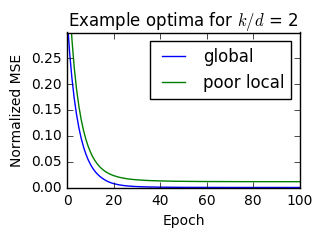

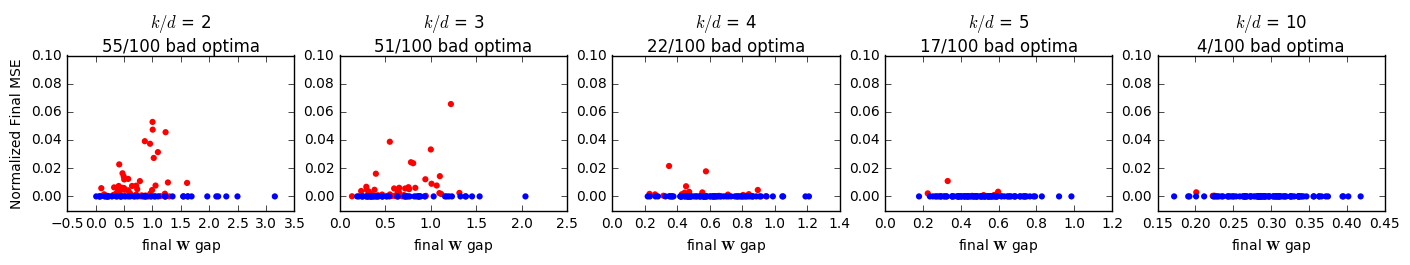

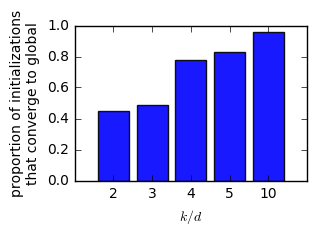

In [6]:
# a. 

plt.figure(figsize=(3,2))
plt.plot(outputs_2[0][0]/Ys[2][0],label='global')
plt.plot(outputs_2[1][0]/Ys[2][1],label='poor local')
plt.xlim([0,100])
# plt.xscale('log')
plt.ylim([-0,0.3])
plt.xlabel('Epoch')
plt.ylabel('Normalized MSE')
plt.title('Example optima for $k/d$ = 2')
plt.legend()
plt.savefig('Figures/fig11a_LossDuringTraining.pdf', 
            format='pdf', dpi=500, bbox_inches='tight')

# b.

prop_global_optima = []
plt.figure(figsize=(17,2))
for ii,r in enumerate([2,3,4,5,10]):
    plt.subplot(1,5,ii+1)
    final_losses = np.array([outputs[r][i][-2]/Ys[r][i] for i in range(num_sims)])
    final_w_gaps = np.array([outputs[r][i][-1]/Ys[r][i]  for i in range(num_sims)])
    inds = final_losses > 1e-6
    prop_global_optima.append(1-float(np.sum(inds))/len(final_losses))
    plt.scatter(final_w_gaps[inds],final_losses[inds],c='r',edgecolor='none')
    plt.scatter(final_w_gaps[np.logical_not(inds)],final_losses[np.logical_not(inds)],edgecolor='none')
    plt.title('$k/d$ = %s\n%s/%s bad optima'%(r,np.sum(inds),len(inds)))
    plt.ylim(-0.01,0.1)
    plt.xlabel('final $\mathbf{W}$ gap')
    if ii == 0: plt.ylabel('Normalized Final MSE')
plt.savefig('Figures/fig11b_lossesForDifferentr.pdf', 
            format='pdf', dpi=500, bbox_inches='tight')
        
# c. 

plt.figure(figsize=(3,2))
plt.bar(np.arange(5),prop_global_optima,align='center',alpha=0.9)
plt.xticks(np.arange(5),('2','3','4','5','10'))
plt.ylim(0,1)
plt.xlabel('$k/d$')
plt.ylabel('proportion of initializations\nthat converge to global')
plt.savefig('Figures/fig11c_propOfGlobalOptFound.pdf', 
            format='pdf', dpi=500, bbox_inches='tight')